In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt

Filtered Gyro Data Shape: (5550341, 3)
Original Gyro Data Shape: (5550341, 13)


C:\Users\LEE\anaconda3\envs\dh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


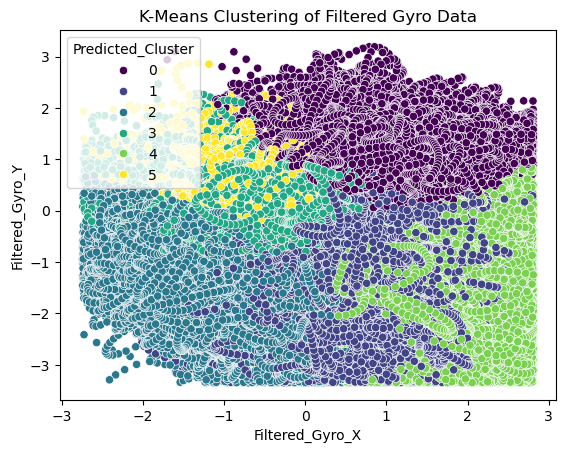

클러스터링 결과 예시:
   WorkDate  UserCode     X     Y     Z         RegisterDate  Filtered_Gyro_X  \
0  20230803         1 -0.01  0.00  0.00  2023-08-03 10:34:41         2.209396   
1  20230803         1  0.05 -0.02 -0.02  2023-08-03 10:32:47         2.209400   
2  20230803         1  0.06  0.12  0.08  2023-08-03 10:30:12         2.209403   
3  20230803         1  0.02  0.02 -0.01  2023-08-03 10:33:41         2.209406   
4  20230803         1  0.17  0.05  0.01  2023-08-03 10:33:03         2.209408   

   Filtered_Gyro_Y  Filtered_Gyro_Z  Magnitude  Diff_Gyro_X  Diff_Gyro_Y  \
0        -0.966461        -0.327500   0.006155     0.000000     0.000000   
1        -0.966461        -0.327500   0.004134     0.006586     0.002372   
2        -0.966460        -0.327500   0.009137     0.006012     0.002177   
3        -0.966459        -0.327500   0.014291     0.005118     0.001856   
4        -0.966459        -0.327501   0.018382     0.003950     0.001427   

   Diff_Gyro_Z  Predicted_Cluster  
0     0

In [2]:
# 1. 저역 통과 필터 적용 함수 정의
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

# 필터링 파라미터 설정
cutoff = 2.0  # 컷오프 주파수 (Hz)
fs = 50.0     # 샘플링 주파수 (Hz)
order = 4     # 필터 차수

# 2. UCI-HAR 데이터 로드 및 전처리
def load_ucihar_gyro_data():
    gyro_x_train_path = './원본 데이터/UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt'
    gyro_y_train_path = './원본 데이터/UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt'
    gyro_z_train_path = './원본 데이터/UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt'
    
    # 자이로스코프 데이터 로드
    gyro_x_train = pd.read_csv(gyro_x_train_path, sep='\s+', header=None).values
    gyro_y_train = pd.read_csv(gyro_y_train_path, sep='\s+', header=None).values
    gyro_z_train = pd.read_csv(gyro_z_train_path, sep='\s+', header=None).values

    # 자이로 데이터를 결합하여 입력 데이터로 만듭니다.
    X_train = np.stack((gyro_x_train, gyro_y_train, gyro_z_train), axis=2)
    
    return X_train

X_train_ucihar = load_ucihar_gyro_data()

# UCI-HAR 데이터를 정규화
scaler = StandardScaler()
X_train_ucihar_normalized = scaler.fit_transform(X_train_ucihar.reshape(-1, X_train_ucihar.shape[-1])).reshape(X_train_ucihar.shape)

# 3. 자이로 데이터 로드 및 전처리
gyro_data = pd.read_csv('./원본 데이터/자이로 데이터.csv')
gyro_data_values = gyro_data[['X', 'Y', 'Z']].values

# 자이로 데이터를 정규화
gyro_data_normalized = scaler.fit_transform(gyro_data_values)

# 저역 통과 필터 적용
gyro_data_filtered_X = butter_lowpass_filter(gyro_data['X'].values, cutoff, fs, order)
gyro_data_filtered_Y = butter_lowpass_filter(gyro_data['Y'].values, cutoff, fs, order)
gyro_data_filtered_Z = butter_lowpass_filter(gyro_data['Z'].values, cutoff, fs, order)

# 필터링된 데이터를 데이터프레임에 저장
gyro_data['Filtered_Gyro_X'] = gyro_data_filtered_X
gyro_data['Filtered_Gyro_Y'] = gyro_data_filtered_Y
gyro_data['Filtered_Gyro_Z'] = gyro_data_filtered_Z

# 4. 자이로스코프 벡터 크기 및 차분 값 계산
gyro_data['Magnitude'] = np.sqrt(gyro_data['Filtered_Gyro_X']**2 + gyro_data['Filtered_Gyro_Y']**2 + gyro_data['Filtered_Gyro_Z']**2)
gyro_data['Diff_Gyro_X'] = gyro_data['Filtered_Gyro_X'].diff().fillna(0)
gyro_data['Diff_Gyro_Y'] = gyro_data['Filtered_Gyro_Y'].diff().fillna(0)
gyro_data['Diff_Gyro_Z'] = gyro_data['Filtered_Gyro_Z'].diff().fillna(0)

# 5. IQR을 이용한 이상치 제거
Q1 = gyro_data[['Filtered_Gyro_X', 'Filtered_Gyro_Y', 'Filtered_Gyro_Z']].quantile(0.25)
Q3 = gyro_data[['Filtered_Gyro_X', 'Filtered_Gyro_Y', 'Filtered_Gyro_Z']].quantile(0.75)
IQR = Q3 - Q1

gyro_data = gyro_data[~(
    (gyro_data['Filtered_Gyro_X'] < (Q1['Filtered_Gyro_X'] - 1.5 * IQR['Filtered_Gyro_X'])) | 
    (gyro_data['Filtered_Gyro_X'] > (Q3['Filtered_Gyro_X'] + 1.5 * IQR['Filtered_Gyro_X'])) |
    (gyro_data['Filtered_Gyro_Y'] < (Q1['Filtered_Gyro_Y'] - 1.5 * IQR['Filtered_Gyro_Y'])) | 
    (gyro_data['Filtered_Gyro_Y'] > (Q3['Filtered_Gyro_Y'] + 1.5 * IQR['Filtered_Gyro_Y'])) |
    (gyro_data['Filtered_Gyro_Z'] < (Q1['Filtered_Gyro_Z'] - 1.5 * IQR['Filtered_Gyro_Z'])) | 
    (gyro_data['Filtered_Gyro_Z'] > (Q3['Filtered_Gyro_Z'] + 1.5 * IQR['Filtered_Gyro_Z']))
)]

# 필터링된 데이터를 다시 정규화
gyro_data[['Filtered_Gyro_X', 'Filtered_Gyro_Y', 'Filtered_Gyro_Z']] = scaler.fit_transform(
    gyro_data[['Filtered_Gyro_X', 'Filtered_Gyro_Y', 'Filtered_Gyro_Z']])

# 필터링된 자이로 데이터를 결합하여 사용 (누락된 부분 추가)
filtered_gyro_data = np.vstack((gyro_data['Filtered_Gyro_X'], gyro_data['Filtered_Gyro_Y'], gyro_data['Filtered_Gyro_Z'])).T

# 클러스터링에 사용한 데이터의 크기 확인
print(f"Filtered Gyro Data Shape: {filtered_gyro_data.shape}")
print(f"Original Gyro Data Shape: {gyro_data.shape}")

# K-Means 클러스터링
n_clusters = 6  # 클러스터 개수 설정
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(filtered_gyro_data)

# 예측된 클러스터 라벨 추가
gyro_data['Predicted_Cluster'] = kmeans.labels_

# 클러스터 시각화
sns.scatterplot(x=gyro_data['Filtered_Gyro_X'], y=gyro_data['Filtered_Gyro_Y'], hue=gyro_data['Predicted_Cluster'], palette='viridis')
plt.title('K-Means Clustering of Filtered Gyro Data')
plt.show()

# 라벨링된 자이로 데이터 저장
gyro_data.to_csv('./원본 데이터/filtered_clustered_gyro_data.csv', index=False)

print("클러스터링 결과 예시:")
print(gyro_data.head())

Predicted_Label        -1      0   1       2
Predicted_Cluster                           
0                  978032  69697   3  175023
1                  525632  69022   0   62471
2                  674318  27398   2  141185
3                  995764  44136   0  204456
4                  366024  81350   0   10113
5                  900555  25394   9  199757
최종 예측된 라벨링 결과 예시:
   Filtered_Gyro_X  Filtered_Gyro_Y  Filtered_Gyro_Z  Predicted_Cluster  \
0         2.209396        -0.966461        -0.327500                  4   
1         2.209400        -0.966461        -0.327500                  4   
2         2.209403        -0.966460        -0.327500                  4   
3         2.209406        -0.966459        -0.327500                  4   
4         2.209408        -0.966459        -0.327501                  4   

   Predicted_Label activity  
0                0      NaN  
1               -1      NaN  
2               -1      NaN  
3               -1      NaN  
4               -1   

C:\Users\LEE\anaconda3\envs\dh\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


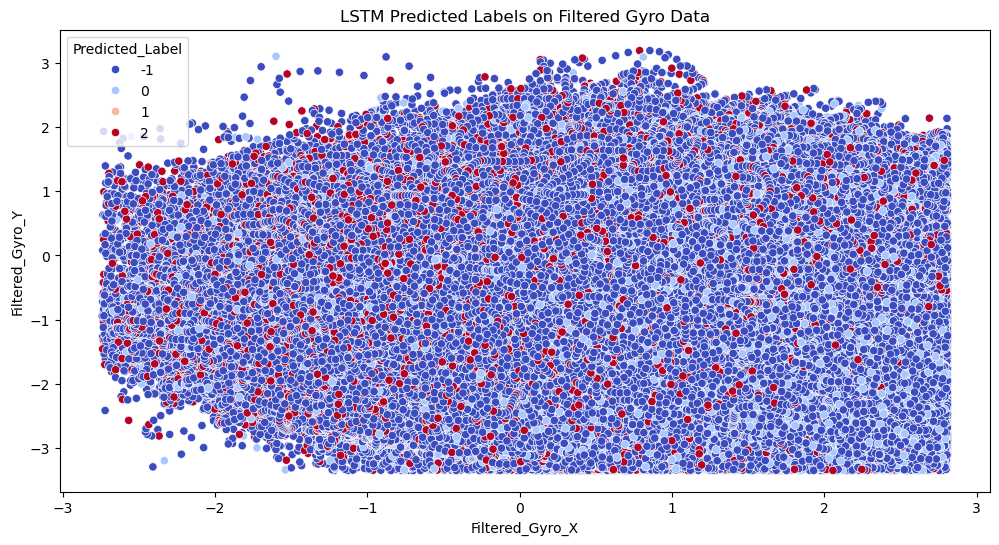

In [5]:
### 7. LSTM 모델을 사용한 행동 예측 (슬라이딩 윈도우 방식 적용) ###
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력 사용
        return out

# 슬라이딩 윈도우 방식으로 시퀀스를 생성하는 함수
def sliding_window_sequences(data, seq_len, step=1):
    sequences = []
    for i in range(0, len(data) - seq_len + 1, step):
        sequences.append(data[i:i + seq_len])
    return np.array(sequences)

# 시퀀스를 배치로 나누는 함수
def create_batches(data, batch_size):
    batches = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        batches.append(batch)
    return np.array(batches)

# LSTM 모델 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 3  # X, Y, Z
hidden_size = 128
num_layers = 2
num_classes = 6

model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes).to(device)

# 필터링된 자이로 데이터를 슬라이딩 윈도우 방식으로 시퀀스 형태로 변환
seq_len = 50  # 시퀀스 길이 설정
step = 5  # 슬라이딩 윈도우의 스텝
filtered_gyro_data_sequences = sliding_window_sequences(filtered_gyro_data, seq_len, step)

# 배치 크기 설정
batch_size = 64  # 메모리 상황에 따라 더 작게 설정 가능
filtered_gyro_data_batches = create_batches(filtered_gyro_data_sequences, batch_size)

# 모델을 평가 모드로 전환
model.eval()

predicted_labels_all = []

# 배치 단위로 예측 수행
for batch in filtered_gyro_data_batches:
    batch_tensor = torch.tensor(batch, dtype=torch.float32).to(device)
    with torch.no_grad():
        outputs = model(batch_tensor)
        _, predicted_labels = torch.max(outputs, 1)
        predicted_labels_all.extend(predicted_labels.cpu().numpy())

# 예측된 라벨의 길이를 gyro_data에 맞춰 조정
final_predicted_labels = predicted_labels_all[:len(gyro_data)]

# 예측된 라벨을 자이로 데이터에 추가
gyro_data['Predicted_Label'] = final_predicted_labels

# 예측된 라벨과 클러스터 라벨 간의 일치율 비교
cluster_vs_lstm = pd.crosstab(gyro_data['Predicted_Cluster'], gyro_data['Predicted_Label'])
print(cluster_vs_lstm)

# 활동 라벨 로드 (UCI-HAR의 activity_labels.txt)
def load_activity_labels():
    activity_labels_path = './원본 데이터/UCI HAR Dataset/activity_labels.txt'
    activity_labels = pd.read_csv(activity_labels_path, sep=' ', header=None, names=['id', 'activity'])
    return activity_labels

activity_labels = load_activity_labels()

# 예측된 라벨을 활동 라벨로 매핑하여 추가
gyro_data = gyro_data.merge(activity_labels, left_on='Predicted_Label', right_on='id', how='left')

# 라벨링된 자이로 데이터 저장
gyro_data.to_csv('./원본 데이터/labeled_filtered_gyro_data.csv', index=False)

print("최종 예측된 라벨링 결과 예시:")
print(gyro_data[['Filtered_Gyro_X', 'Filtered_Gyro_Y', 'Filtered_Gyro_Z', 'Predicted_Cluster', 'Predicted_Label', 'activity']].head())

# 시각화 - 클러스터와 LSTM 예측 라벨 비교
plt.figure(figsize=(12, 6))
sns.scatterplot(x=gyro_data['Filtered_Gyro_X'], y=gyro_data['Filtered_Gyro_Y'], hue=gyro_data['Predicted_Label'], palette='coolwarm')
plt.title('LSTM Predicted Labels on Filtered Gyro Data')
plt.show()
